### Import required packages

In [1]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from pyod.models.knn import KNN
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier
from math import sqrt
from sklearn.feature_selection import SelectFromModel
from imblearn.over_sampling import SMOTE
from sklearn.datasets import make_classification


In [2]:
# Data from Ethiopia
Births_Ethiopia = pd.read_sas('Births_Ethiopia.SAS7BDAT')
print(Births_Ethiopia.shape)

# 'M19': Birth_Weight: Birth weight in kilograms (3 decimals) [Original Response variable]
print("The number of valid samples in the dataset is " + str(len(Births_Ethiopia['M19'].dropna())))
                                                            
Births_Ethiopia.head()


(41392, 1287)
The number of valid samples in the dataset is 10641


,CASEID,BIDX,V000,V001,V002,V003,V004,V005,V006,V007,...,SD508NC,SM508NC,SD508RA,SM508RA,SD508RB,SM508RB,SD508MA,SM508MA,SD508VA,SM508VA
0,b' 1 17 2',1.0,b'ET7',1.0,17.0,2.0,1.0,5087433.0,9.0,2008.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,b' 1 17 2',2.0,b'ET7',1.0,17.0,2.0,1.0,5087433.0,9.0,2008.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,b' 1 17 2',3.0,b'ET7',1.0,17.0,2.0,1.0,5087433.0,9.0,2008.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,b' 1 17 2',4.0,b'ET7',1.0,17.0,2.0,1.0,5087433.0,9.0,2008.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,b' 1 17 2',5.0,b'ET7',1.0,17.0,2.0,1.0,5087433.0,9.0,2008.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Original 17 features
'V026': Residence: Type of place of residence (Large city/ Small city/ Town/ Countryside)

'V106': Education: Educational level (no education/primary/secondary or higher)

'H42': Iron: Taking iron pills, sprinkles or syrup

'V190': Wealth: Wealth index combined (Poorest/poorer/middle/richer/richest)

'V445': BMI: Body mass index (numerical)

'V447A': Age_W: Women's age in years (numerical)

'V457': Anemia: Anemia level (severe/ moderate /mild/not anemic)

'V463A': Smoking: Smokes cigarettes (no/yes)

'V481': Insurance: Covered by health insurance (no/yes)

'V717': Occupation: Respondent's occupation

'V131': Ethnicity: Ethnicity (Amahara/Oromo/Tigrie/Somali/Guragie/Others

'V501': Marital: Current marital status

'V130': Religion: Religion(orthodox/muslim/protestant/others)

'B4': Gender: Sex of child (male/female)

'B0': Twin: The child is a twin (single/multiple)

'M14': Visits: Number of antenatal visits during pregnancy (numerical)

'M17': Delivery_Caesarean: Delivery by caesarean section (no/yes)

In [3]:
Births_Ethiopia_df = Births_Ethiopia[['M19','V026','V106','H42','V190','V445','V447A','V457','V463A','V481','V717','V131',
                  'V501','V130','B4','B0','M14','M17']]
Births_Ethiopia_df.columns = ['Birth_Weight','Residence','Education','Iron','Wealth','BMI','Age_W','Anemia',
                     'Smoking','Insurance','Occupation','Ethnicity','Marital','Religion','Gender',
                    'Twin','Visits','Delivery_Caesarean']
Births_Ethiopia_df = Births_Ethiopia_df.dropna(subset=['Birth_Weight'])
Births_Ethiopia_df = Births_Ethiopia_df.reset_index()
Births_Ethiopia_df = Births_Ethiopia_df.iloc[:,1:]
print(Births_Ethiopia_df.shape)
Births_Ethiopia_df.head()

(10641, 18)


,Birth_Weight,Residence,Education,Iron,Wealth,BMI,Age_W,Anemia,Smoking,Insurance,Occupation,Ethnicity,Marital,Religion,Gender,Twin,Visits,Delivery_Caesarean
0,9996.0,NaN,0.0,0.0,2.0,1765.0,38.0,4.0,0.0,0.0,0.0,2.0,1.0,4.0,1.0,0.0,0.0,0.0
1,9996.0,NaN,0.0,1.0,2.0,1765.0,38.0,4.0,0.0,0.0,0.0,2.0,1.0,4.0,1.0,0.0,NaN,0.0
2,9996.0,NaN,0.0,0.0,2.0,1765.0,38.0,4.0,0.0,0.0,0.0,2.0,1.0,4.0,2.0,0.0,NaN,0.0
3,9996.0,NaN,1.0,NaN,2.0,2372.0,42.0,4.0,0.0,0.0,0.0,2.0,1.0,4.0,1.0,0.0,0.0,0.0
4,9996.0,NaN,0.0,0.0,2.0,1913.0,46.0,4.0,0.0,0.0,5.0,2.0,1.0,4.0,1.0,0.0,0.0,0.0


## Data Pre-processing

In [4]:
# Categorical variables: one-hot encoding
enc = OneHotEncoder(sparse=False)
encoded_array = enc.fit_transform(Births_Ethiopia_df[['Residence', 'Education', 'Iron', 'Wealth', 'Anemia', 'Smoking', 'Insurance', 'Occupation', 'Ethnicity', 'Marital', 'Religion', 'Gender', 'Twin', 'Delivery_Caesarean']])

encoded_cols = enc.get_feature_names_out(['Residence', 'Education', 'Iron', 'Wealth', 'Anemia', 'Smoking', 'Insurance', 'Occupation', 'Ethnicity', 'Marital', 'Religion', 'Gender', 'Twin', 'Delivery_Caesarean'])
encoded_df = pd.DataFrame(encoded_array, columns=encoded_cols)

# Drop the original columns that were encoded & concatenate with the other columns
Births_Ethiopia_encoded = pd.concat([Births_Ethiopia_df.drop(['Residence', 'Education', 'Iron', 'Wealth', 'Anemia', 'Smoking', 'Insurance', 'Occupation', 'Ethnicity', 'Marital', 'Religion', 'Gender', 'Twin', 'Delivery_Caesarean'], axis=1), encoded_df], axis=1)

# Drop the encoded columns showing NA or missing value
Births_Ethiopia_encoded = Births_Ethiopia_encoded.drop(['Residence_nan', 'Iron_8.0', 'Iron_nan', 'Anemia_nan', 'Occupation_96.0', 'Ethnicity_6.0', 'Ethnicity_7.0', 'Ethnicity_8.0',
       'Ethnicity_9.0', 'Ethnicity_10.0', 'Ethnicity_11.0', 'Ethnicity_12.0',
       'Ethnicity_13.0', 'Ethnicity_14.0', 'Ethnicity_15.0', 'Ethnicity_16.0',
       'Ethnicity_17.0', 'Ethnicity_18.0', 'Ethnicity_19.0', 'Ethnicity_20.0',
       'Ethnicity_22.0', 'Ethnicity_24.0', 'Ethnicity_28.0', 'Ethnicity_33.0',
       'Ethnicity_34.0', 'Ethnicity_35.0', 'Ethnicity_36.0', 'Ethnicity_38.0',
       'Ethnicity_42.0', 'Ethnicity_43.0', 'Ethnicity_44.0', 'Ethnicity_47.0',
       'Ethnicity_53.0', 'Ethnicity_57.0', 'Ethnicity_59.0', 'Ethnicity_64.0',
       'Ethnicity_71.0', 'Ethnicity_72.0', 'Ethnicity_73.0', 'Ethnicity_75.0',
       'Ethnicity_76.0', 'Ethnicity_85.0', 'Ethnicity_93.0', 'Ethnicity_96.0',
       'Ethnicity_99.0', 'Religion_96.0'], axis=1)
# Births_Ethiopia_encoded.head()

/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


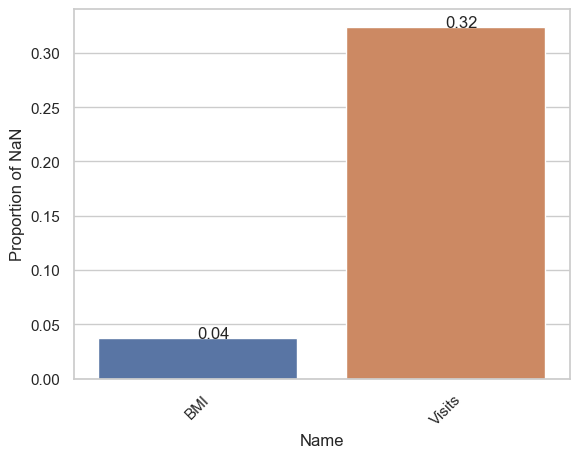

In [5]:
# Numerical variables: imputation
def addlabels(x, y):
    for i in range(len(x)):
        plt.text(i,y[i],round(y[i],2))
        
missing_values = Births_Ethiopia_encoded.isnull().sum() / len(Births_Ethiopia_encoded)
missing_values = missing_values[missing_values > 0]
missing_values.sort_values(inplace=True)
missing_values = missing_values.to_frame()
missing_values.columns = ['Proportion of NaN']
missing_values.index.names = ['Name']
missing_values['Name'] = missing_values.index

sns.set(style="whitegrid", color_codes=True)
sns.barplot(x = 'Name', y = 'Proportion of NaN', data=missing_values)
plt.xticks(rotation = 45)
addlabels(missing_values['Name'], y=missing_values['Proportion of NaN'])
plt.show()

In [6]:
# Impute with mean simpleImputer
imputer_sim = SimpleImputer(strategy = "mean")
imputed_df_sim = imputer_sim.fit_transform(Births_Ethiopia_encoded)
Births_Ethiopia_imputed = pd.DataFrame(imputed_df_sim)
Births_Ethiopia_imputed.columns = Births_Ethiopia_encoded.columns
# Births_Ethiopia_imputed.head()

In [7]:
# Response variable engineering
Births_Ethiopia_imputed["Is_LBW"] = Births_Ethiopia_imputed["Birth_Weight"]<2500
Births_Ethiopia_res = Births_Ethiopia_imputed.drop(['Birth_Weight'], axis=1)
# Births_Ethiopia_res.head()


In [8]:
Y_Ethiopia = Births_Ethiopia_res["Is_LBW"]
Feature_Ethiopia = Births_Ethiopia_res.drop(["Is_LBW"], axis=1)


In [9]:
# Lasso for feature selection
lasso = LogisticRegression(penalty='l1', solver='liblinear', C=1.0, random_state=42)
lasso.fit(Feature_Ethiopia, Y_Ethiopia)

coefficients = lasso.coef_[0]
# Identify columns that were dropped (coefficients are zero)
selected_columns = Feature_Ethiopia.columns[coefficients != 0]
# print("Selected columns:", selected_columns)

# Select features based on the weights after Lasso regularization
feature_model = SelectFromModel(lasso, prefit=True)

# Transform the dataset to only include the selected features
Feature_new = feature_model.transform(Feature_Ethiopia)

# Update Feature df
Feature_Ethiopia = pd.DataFrame(Feature_new, columns = ['BMI', 'Age_W', 'Visits', 'Education_0.0', 'Education_2.0',
       'Education_3.0', 'Iron_0.0', 'Iron_1.0', 'Wealth_1.0', 'Wealth_2.0',
       'Wealth_4.0', 'Wealth_5.0', 'Anemia_3.0', 'Anemia_4.0', 'Smoking_0.0',
       'Insurance_0.0', 'Occupation_1.0', 'Occupation_2.0', 'Occupation_5.0',
       'Occupation_8.0', 'Occupation_9.0', 'Ethnicity_1.0', 'Ethnicity_2.0',
       'Ethnicity_3.0', 'Ethnicity_4.0', 'Ethnicity_5.0', 'Marital_0.0',
       'Marital_1.0', 'Marital_2.0', 'Marital_4.0', 'Marital_5.0',
       'Religion_1.0', 'Religion_4.0', 'Gender_1.0', 'Twin_0.0', 'Twin_1.0',
       'Delivery_Caesarean_1.0'])
# Feature_Ethiopia.head()

/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


In [10]:
# Whole Ethiopia df after data pre-processing
Ethiopia_final = pd.concat([Feature_Ethiopia, Y_Ethiopia], 1)
Ethiopia_final.head()

/var/folders/nl/c2qd572x47jc6xs5b3g_cp800000gn/T/ipykernel_34302/199189670.py:2: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  Ethiopia_final = pd.concat([Feature_Ethiopia, Y_Ethiopia], 1)


,BMI,Age_W,Visits,Education_0.0,Education_2.0,Education_3.0,Iron_0.0,Iron_1.0,Wealth_1.0,Wealth_2.0,...,Marital_2.0,Marital_4.0,Marital_5.0,Religion_1.0,Religion_4.0,Gender_1.0,Twin_0.0,Twin_1.0,Delivery_Caesarean_1.0,Is_LBW
0,1765.0,38.0,0.000000,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,False
1,1765.0,38.0,2.881134,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,False
2,1765.0,38.0,2.881134,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,False
3,2372.0,42.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,False
4,1913.0,46.0,0.000000,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,False


## Model construction and Evaluation (baseline models)

### Data split

In [11]:
# Split training and testing set
X_train_Ethiopia, X_test_Ethiopia, Y_train_Ethiopia, Y_test_Ethiopia = train_test_split(Feature_Ethiopia, Y_Ethiopia, test_size=0.25, random_state=42)


In [12]:
# Scale X if needed
scaler = StandardScaler()
X_train_Ethiopia_scaled = scaler.fit_transform(X_train_Ethiopia)
X_test_Ethiopia_scaled = scaler.transform(X_test_Ethiopia)

In [13]:
# Get confidence interval for auc score
def roc_auc_ci(y_true, y_score, AUC, positive=True):
    N1 = sum(y_true)
    N2 = len(y_true) - N1
    Q1 = AUC / (2 - AUC)
    Q2 = 2*AUC**2 / (1 + AUC)
    SE_AUC = sqrt((AUC*(1 - AUC) + (N1 - 1)*(Q1 - AUC**2) + (N2 - 1)*(Q2 - AUC**2)) / (N1*N2))
    lower = AUC - 1.96*SE_AUC
    upper = AUC + 1.96*SE_AUC
    if lower < 0:
        lower = 0
    if upper > 1:
        upper = 1
    return (lower, upper)

### Logistic regression

In [14]:
lr_model_Ethiopia = LogisticRegression(solver='liblinear', random_state=42)
lr_model_Ethiopia.fit(X_train_Ethiopia, Y_train_Ethiopia)
lr_predict_Ethiopia = lr_model_Ethiopia.predict(X_test_Ethiopia)
lr_score_Ethiopia = lr_model_Ethiopia.predict_proba(X_test_Ethiopia)[:,1]
lr_auc_Ethiopia = roc_auc_score(Y_test_Ethiopia, lr_score_Ethiopia)
print('roc_auc_score for Logistic Regression in Ethiopic data (without resampling): ', lr_auc_Ethiopia)
print('Confidence interval for AUC in Logistic Regression is: ', roc_auc_ci(Y_test_Ethiopia, lr_score_Ethiopia, lr_auc_Ethiopia))

roc_auc_score for Logistic Regression in Ethiopic data (without resampling):  0.7418963231703063
Confidence interval for AUC in LR is:  (0.6660260446142774, 0.8177666017263352)


### Decision tree

In [15]:
dt_model = DecisionTreeClassifier(random_state=42)
dt_param_grid = {'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]}
dt_grid_search = GridSearchCV(estimator=dt_model, param_grid=dt_param_grid, cv=5, scoring='roc_auc')
dt_grid_search.fit(X_train_Ethiopia, Y_train_Ethiopia)
dt_best_params = dt_grid_search.best_params_
print(dt_best_params)


{'max_depth': 3}


In [16]:
dt_model_Ethiopia = dt_grid_search.best_estimator_
dt_model_Ethiopia.fit(X_train_Ethiopia, Y_train_Ethiopia)
dt_predict_Ethiopia = dt_model_Ethiopia.predict(X_test_Ethiopia)
dt_score_Ethiopia = dt_model_Ethiopia.predict_proba(X_test_Ethiopia)[:,1]
dt_auc_Ethiopia = roc_auc_score(Y_test_Ethiopia, dt_score_Ethiopia)
print('roc_auc_score for Decision Tree in Ethiopic data (without resampling): ', dt_auc_Ethiopia)
print('Confidence interval for AUC in Decision Tree is: ', roc_auc_ci(Y_test_Ethiopia, dt_score_Ethiopia, dt_auc_Ethiopia))

roc_auc_score for Decision Tree in Ethiopic data (without resampling):  0.7374973836600852
Confidence interval for AUC in DT is:  (0.6613342515053606, 0.8136605158148098)


### Linear SVM

In [17]:
svm_model_Ethiopia = SVC(kernel='linear', probability=True)
svm_model_Ethiopia.fit(X_train_Ethiopia, Y_train_Ethiopia)
svm_predict_Ethiopia = svm_model_Ethiopia.predict(X_test_Ethiopia)
svm_score_Ethiopia = svm_model_Ethiopia.predict_proba(X_test_Ethiopia)[:,1]
svm_auc_Ethiopia = roc_auc_score(Y_test_Ethiopia, svm_score_Ethiopia)
print('roc_auc_score for Linear Support Vectore Machine in Ethiopic data (without resampling): ', svm_auc_Ethiopia)
print('Confidence interval for AUC in Linear SVM is: ', roc_auc_ci(Y_test_Ethiopia, svm_score_Ethiopia, svm_auc_Ethiopia))

roc_auc_score for Linear Support Vectore Machine in Ethiopic data (without resampling):  0.6075978511128165
Confidence interval for AUC in SVM is:  (0.527626881510343, 0.68756882071529)


### KNN

In [18]:
knn_model = KNeighborsClassifier()
knn_param_grid = {'n_neighbors': [10, 15, 20, 30, 40, 50, 60, 80, 100]}
knn_grid_search = GridSearchCV(knn_model, knn_param_grid, cv=5, scoring='roc_auc')
knn_grid_search.fit(X_train_Ethiopia, Y_train_Ethiopia)
knn_best_params = knn_grid_search.best_params_
print(knn_best_params)

{'n_neighbors': 80}


In [19]:
knn_model_Ethiopia = knn_grid_search.best_estimator_
knn_model_Ethiopia.fit(X_train_Ethiopia, Y_train_Ethiopia)
knn_predict_Ethiopia = knn_model_Ethiopia.predict(X_test_Ethiopia)
knn_score_Ethiopia = knn_model_Ethiopia.predict_proba(X_test_Ethiopia)[:,1]
knn_auc_Ethiopia = roc_auc_score(Y_test_Ethiopia, knn_score_Ethiopia)
print('roc_auc_score for K-nearest Neighbors in Ethiopic data (without resampling): ', knn_auc_Ethiopia)
print('Confidence interval for AUC in KNN is: ', roc_auc_ci(Y_test_Ethiopia, knn_score_Ethiopia, knn_auc_Ethiopia))

roc_auc_score for K-nearest Neighbors in Ethiopic data (without resampling):  0.5203865206167585
Confidence interval for AUC in KNN is:  (0.44235923715939307, 0.5984138040741239)


### Random Forest

In [20]:
rf_model = RandomForestClassifier(random_state=42)
rf_param_rand = {'n_estimators': range(2, 20), 'max_depth': range(2,15)}
rf_rand_search = RandomizedSearchCV(rf_model, param_distributions = rf_param_rand, n_iter=5, cv=5,random_state = 42)
rf_rand_search.fit(X_train_Ethiopia, Y_train_Ethiopia)
rf_best_params = rf_rand_search.best_params_
print(rf_best_params)

{'n_estimators': 17, 'max_depth': 5}


In [21]:
rf_model_Ethiopia = rf_rand_search.best_estimator_
rf_model_Ethiopia.fit(X_train_Ethiopia, Y_train_Ethiopia)
rf_predict_Ethiopia = rf_model_Ethiopia.predict(X_test_Ethiopia)
rf_score_Ethiopia = rf_model_Ethiopia.predict_proba(X_test_Ethiopia)[:,1]
rf_auc_Ethiopia = roc_auc_score(Y_test_Ethiopia, rf_score_Ethiopia)
print('roc_auc_score for Random Forest in Ethiopic data (without resampling): ', rf_auc_Ethiopia)
print('Confidence interval for AUC in Random Forest is: ', roc_auc_ci(Y_test_Ethiopia, rf_score_Ethiopia, rf_auc_Ethiopia))

roc_auc_score for Random Forest in Ethiopic data (without resampling):  0.759422312146794
Confidence interval for AUC in RF is:  (0.6848424424397086, 0.8340021818538794)


### Adaboosting

In [22]:
ada_model = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(random_state=42))
ada_param_grid = {'base_estimator__max_depth': [1, 2], 'n_estimators': range(100, 275, 25), 'learning_rate': [0.01, 0.02, 0.05]}
ada_grid_search = GridSearchCV(ada_model, ada_param_grid, cv=5, scoring='roc_auc')
ada_grid_search.fit(X_train_Ethiopia, Y_train_Ethiopia)
ada_best_params = ada_grid_search.best_params_
print(ada_best_params)

/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warni

/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warni

/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warni

/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warni

/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warni

/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warni

{'base_estimator__max_depth': 1, 'learning_rate': 0.05, 'n_estimators': 150}


In [23]:
ada_model_Ethiopia = ada_grid_search.best_estimator_
ada_model_Ethiopia.fit(X_train_Ethiopia, Y_train_Ethiopia)
ada_predict_Ethiopia = ada_model_Ethiopia.predict(X_test_Ethiopia)
ada_score_Ethiopia = ada_model_Ethiopia.predict_proba(X_test_Ethiopia)[:,1]
ada_auc_Ethiopia = roc_auc_score(Y_test_Ethiopia, ada_score_Ethiopia)
print('roc_auc_score for Adaboosting in Ethiopic data (without resampling): ', ada_auc_Ethiopia)
print('Confidence interval for AUC in Adaboosting is: ', roc_auc_ci(Y_test_Ethiopia, ada_score_Ethiopia, ada_auc_Ethiopia))

/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


roc_auc_score for Adaboosting in Ethiopic data (without resampling):  0.7732261215377102
Confidence interval for AUC in ADA is:  (0.6998082741785694, 0.846643968896851)


### Bagging

In [24]:
bag_model = BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=42), random_state=42)
bag_param_grid = {'n_estimators': range(100, 275, 25),
                  'base_estimator__max_depth': [3, 4, 5, 6],
                  'max_samples': [0.3, 0.5, 0.7, 1.0],
                  'max_features': [0.3, 0.5, 0.7, 1.0]}
bag_grid_search = GridSearchCV(bag_model, bag_param_grid, cv=5, scoring='roc_auc')
bag_grid_search.fit(X_train_Ethiopia_scaled, Y_train_Ethiopia)
bag_best_params = bag_grid_search.best_params_
print(bag_best_params)

/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warni

/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warni

/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warni

/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warni

/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warni

/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warni

/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warni

/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warni

/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warni

/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warni

/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warni

/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warni

/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warni

/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warni

/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warni

/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warni

/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warni

/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warni

/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warni

/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warni

/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warni

/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warni

/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warni

/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warni

/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warni

/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warni

/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warni

/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warni

/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warni

/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warni

/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warni

/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warni

/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warni

/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warni

/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warni

/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warni

/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warni

/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warni

/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warni

/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warni

/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warni

/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warni

/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warni

/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warni

/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warni

/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warni

/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warni

/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warni

/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warni

/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warni

/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warni

/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warni

/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warni

/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warni

/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warni

{'base_estimator__max_depth': 3, 'max_features': 0.7, 'max_samples': 1.0, 'n_estimators': 100}


In [25]:
bag_model_Ethiopia = bag_grid_search.best_estimator_
bag_model_Ethiopia.fit(X_train_Ethiopia_scaled, Y_train_Ethiopia)
bag_predict_Ethiopia = bag_model_Ethiopia.predict(X_test_Ethiopia_scaled)
bag_score_Ethiopia = bag_model_Ethiopia.predict_proba(X_test_Ethiopia_scaled)[:,1]
bag_auc_Ethiopia = roc_auc_score(Y_test_Ethiopia, bag_score_Ethiopia)
print('roc_auc_score for Bagging in Ethiopic data (without resampling): ', bag_auc_Ethiopia)
print('Confidence interval for AUC in Bagging is: ', roc_auc_ci(Y_test_Ethiopia, bag_score_Ethiopia, bag_auc_Ethiopia))

/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


roc_auc_score for Bagging in Ethiopic data (without resampling):  0.762101444219633
Confidence interval for AUC in Bagging is:  (0.6877367975283158, 0.8364660909109501)


### Gradient boosting

In [26]:
gb_model = GradientBoostingClassifier(random_state=42)
gb_param_grid = {'n_estimators': range(150, 325, 25), 'learning_rate': [0.01, 0.02, 0.05, 0.1], 'max_depth': [3, 4, 5]}
gb_grid_search = GridSearchCV(gb_model, gb_param_grid, cv=5, scoring='roc_auc')
gb_grid_search.fit(X_train_Ethiopia_scaled, Y_train_Ethiopia)
gb_best_params = gb_grid_search.best_params_
print(gb_best_params)

{'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 275}


In [27]:
gb_model_Ethiopia = gb_grid_search.best_estimator_
gb_model_Ethiopia.fit(X_train_Ethiopia_scaled, Y_train_Ethiopia)
gb_predict_Ethiopia = gb_model_Ethiopia.predict(X_test_Ethiopia_scaled)
gb_score_Ethiopia = gb_model_Ethiopia.predict_proba(X_test_Ethiopia_scaled)[:,1]
gb_auc_Ethiopia = roc_auc_score(Y_test_Ethiopia, gb_score_Ethiopia)
print('roc_auc_score for Gradient Boosting in Ethiopic data (without resampling): ', gb_auc_Ethiopia)
print('Confidence interval for AUC in Gradient Boosting is: ', roc_auc_ci(Y_test_Ethiopia, gb_score_Ethiopia, gb_auc_Ethiopia))

roc_auc_score for Gradient Boosting in Ethiopic data (without resampling):  0.7689667201562828
Confidence interval for AUC in GB is:  (0.6951761138047446, 0.8427573265078209)


## Resampling with SMOTE

In [28]:
sampling_strategies = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

classifiers = {
    'LogisticRegression': lr_model_Ethiopia,
    'DecisionTree': dt_model_Ethiopia,
    'SVM': svm_model_Ethiopia,
    'KNN': knn_model_Ethiopia,
    'RandomForest': rf_model_Ethiopia,
    'Adaboosting': ada_model_Ethiopia,
    'Bagging': bag_model_Ethiopia,
    'GradientBoosting': gb_model_Ethiopia
}

for strategy in sampling_strategies:
    print(f"SMOTE Sampling Strategy: {strategy}")
    
    # Apply SMOTE with the current sampling strategy
    smote = SMOTE(sampling_strategy=strategy, random_state=42)
    X_train_smote, Y_train_smote = smote.fit_resample(X_train_Ethiopia, Y_train_Ethiopia)
    X_train_smote_scaled, Y_train_smote_scaled = smote.fit_resample(X_train_Ethiopia_scaled, Y_train_Ethiopia)
    
    # Iterate over classifiers
    for name, clf in classifiers.items():
        if name=='GradientBoosting' or name=='Bagging':
            clf.fit(X_train_smote_scaled, Y_train_smote_scaled)
            y_pred_proba = clf.predict_proba(X_test_Ethiopia_scaled)[:, 1]
        else:
            clf.fit(X_train_smote, Y_train_smote)
            y_pred_proba = clf.predict_proba(X_test_Ethiopia)[:, 1]

        auc_score = roc_auc_score(Y_test_Ethiopia, y_pred_proba)
        print(f"{name} AUC: {auc_score}")

SMOTE Sampling Strategy: 0.8
LogisticRegression AUC: 0.7527244819646969
DecisionTree AUC: 0.7517512035163608
SVM AUC: 0.7443173097048769
KNN AUC: 0.5415893392869602
RandomForest AUC: 0.7561745621991209


/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Adaboosting AUC: 0.7699190678852997


/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Bagging AUC: 0.7712516570152795
GradientBoosting AUC: 0.7736586897369707
SMOTE Sampling Strategy: 0.9
LogisticRegression AUC: 0.7529686736900859
DecisionTree AUC: 0.7517512035163608
SVM AUC: 0.744135910137445
KNN AUC: 0.5418230656526896
RandomForest AUC: 0.7500697690643967


/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Adaboosting AUC: 0.7713039838135771


/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Bagging AUC: 0.77367264354985
GradientBoosting AUC: 0.7750575594781275
SMOTE Sampling Strategy: 1
LogisticRegression AUC: 0.7536105490825368
DecisionTree AUC: 0.7517512035163608
SVM AUC: 0.7459847903439615
KNN AUC: 0.5437033419381846
RandomForest AUC: 0.7587106676899462


/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Adaboosting AUC: 0.7712725877345985


/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Bagging AUC: 0.7755808274611038
GradientBoosting AUC: 0.7748482522849369


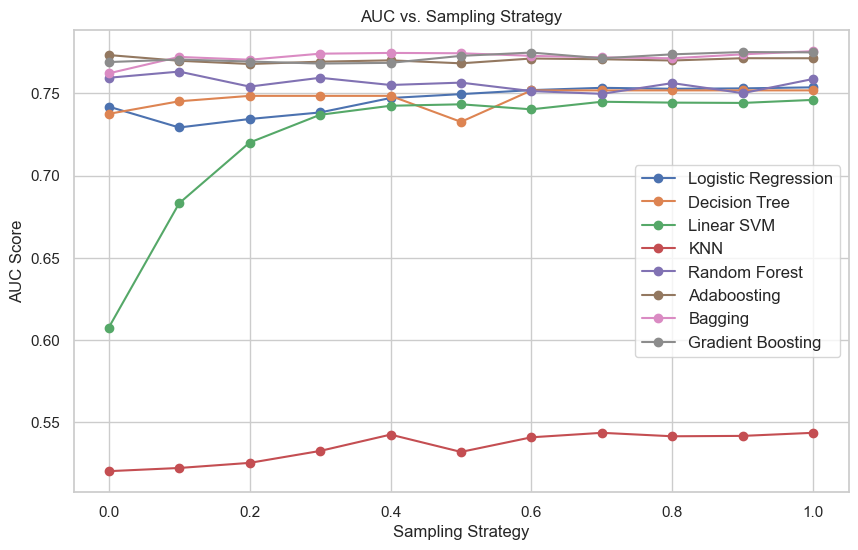

In [17]:
sampling_strategies = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
logistic_regression = [0.7418963231703063, 0.7292123072629597, 0.7343682411218866, 0.7383520546989465, 0.7471220260936301, 0.7494871973766832, 0.7519221377241331, 0.7533105421056304, 0.7527244819646969, 0.7529686736900859, 0.7536105490825368]
decision_tree = [0.7374973836600852, 0.7451405846647596, 0.748430196051071, 0.748430196051071, 0.748430196051071, 0.7326344798716249, 0.7517512035163608, 0.7517512035163608, 0.7517512035163608, 0.7517512035163608, 0.7517512035163608]
linear_svm = [0.6075978511128165, 0.68318565548036, 0.7200586060140932, 0.7369287657852508, 0.7424126142468429, 0.7432917044582433, 0.7402462847973209, 0.7448580199539524, 0.7443173097048769, 0.744135910137445, 0.7459847903439615]
knn = [0.5203865206167585, 0.5223295890602108, 0.5254273355194307, 0.5326798297634829, 0.5426044791739343, 0.5320833042628899, 0.540971883067048, 0.5436893881253052, 0.5415893392869602, 0.5418230656526896, 0.5437033419381846]
random_forest = [0.759422312146794, 0.7631723993581245, 0.7540605595478964, 0.7594118467871346, 0.7550338379962325, 0.7564710807228076, 0.7513256122235401, 0.7496651084908952, 0.7561745621991209, 0.7500697690643967, 0.7587106676899462]
adaboosting = [0.7732261215377102, 0.7697516221307471, 0.7677911114211959, 0.7691934696155724, 0.7700097676690155, 0.7682027489011372, 0.7711190957929255, 0.7706760622340054, 0.7699190678852997, 0.7713039838135771, 0.7712725877345985]
bagging = [0.762101444219633, 0.772081908881602, 0.7703830321635387, 0.7740563734040327, 0.774513360775832, 0.7743145189423011, 0.7727307611804926, 0.7718202748901137, 0.7712516570152795, 0.77367264354985, 0.7755808274611038]
gradient_boosting = [0.7689667201562828, 0.7705051280262332, 0.7692946347589479, 0.7680457685062443, 0.7684922905183842, 0.7727307611804926, 0.7747366217819018, 0.7712481685620596, 0.7736586897369707, 0.7750575594781275, 0.7748482522849369]

plt.figure(figsize=(10, 6))
plt.plot(sampling_strategies, logistic_regression, label='Logistic Regression', marker='o')
plt.plot(sampling_strategies, decision_tree, label='Decision Tree', marker='o')
plt.plot(sampling_strategies, linear_svm, label='Linear SVM', marker='o')
plt.plot(sampling_strategies, knn, label='KNN', marker='o')
plt.plot(sampling_strategies, random_forest, label='Random Forest', marker='o')
plt.plot(sampling_strategies, adaboosting, label='Adaboosting', marker='o')
plt.plot(sampling_strategies, bagging, label='Bagging', marker='o')
plt.plot(sampling_strategies, gradient_boosting, label='Gradient Boosting', marker='o')

plt.xlabel('Sampling Strategy')
plt.ylabel('AUC Score')
plt.title('AUC vs. Sampling Strategy')
plt.legend(fontsize=12)
plt.grid(True)
plt.savefig('Ethiopia_sampling.png', dpi=200, bbox_inches='tight', pad_inches=0)


### Best AUC & SMOTE strategy for each model

logistic_regression: 0.7536105490825368, SMOTE=1

decision_tree: 0.7517512035163608, SMOTE=1

linear_svm: 0.7459847903439615, SMOTE=1

knn: 0.5437033419381846, SMOTE=1

random_forest: 0.7631723993581245, SMOTE=0.1

adaboosting: 0.7732261215377102, SMOTE=0

bagging: 0.7755808274611038, SMOTE=1

gradient_boosting: 0.7750575594781275, SMOTE=0.9

Best model: bagging: 0.7755808274611038, SMOTE=1

### Draw AUC plots with SMOTE strategy

In [14]:
# Initialize SMOTE
smote_1 = SMOTE(sampling_strategy=1, random_state=42)
X_train_Ethiopia_smote_1, Y_train_Ethiopia_smote_1 = smote_1.fit_resample(X_train_Ethiopia, Y_train_Ethiopia)
X_train_Ethiopia_smote_1_scaled, Y_train_Ethiopia_smote_1_scaled = smote_1.fit_resample(X_train_Ethiopia_scaled, Y_train_Ethiopia)

smote_01 = SMOTE(sampling_strategy=0.1, random_state=42)
X_train_Ethiopia_smote_01, Y_train_Ethiopia_smote_01 = smote_01.fit_resample(X_train_Ethiopia, Y_train_Ethiopia)

smote_06 = SMOTE(sampling_strategy=0.6, random_state=42)
X_train_Ethiopia_smote_06, Y_train_Ethiopia_smote_06 = smote_06.fit_resample(X_train_Ethiopia, Y_train_Ethiopia)

smote_09 = SMOTE(sampling_strategy=0.9, random_state=42)
X_train_Ethiopia_smote_09, Y_train_Ethiopia_smote_09 = smote_09.fit_resample(X_train_Ethiopia, Y_train_Ethiopia)
X_train_Ethiopia_smote_09_scaled, Y_train_Ethiopia_smote_09_scaled = smote_09.fit_resample(X_train_Ethiopia_scaled, Y_train_Ethiopia)


### Logistic Regression, SMOTE=1

In [15]:
lr_model_Ethiopia = LogisticRegression(solver='liblinear', random_state=42)
lr_model_Ethiopia.fit(X_train_Ethiopia_smote_1, Y_train_Ethiopia_smote_1)
lr_predict_Ethiopia = lr_model_Ethiopia.predict(X_test_Ethiopia)
lr_score_Ethiopia = lr_model_Ethiopia.predict_proba(X_test_Ethiopia)[:,1]
lr_auc_Ethiopia = roc_auc_score(Y_test_Ethiopia, lr_score_Ethiopia)
print('roc_auc_score for Logistic Regression in Ethiopic data: ', lr_auc_Ethiopia)
print('Confidence interval for AUC in Logistic Regression is: ', roc_auc_ci(Y_test_Ethiopia, lr_score_Ethiopia, lr_auc_Ethiopia))


roc_auc_score for Logistic Regression in Ethiopic data:  0.7536105490825368
Confidence interval for AUC in Logistic Regression is:  (0.6785804240655405, 0.828640674099533)


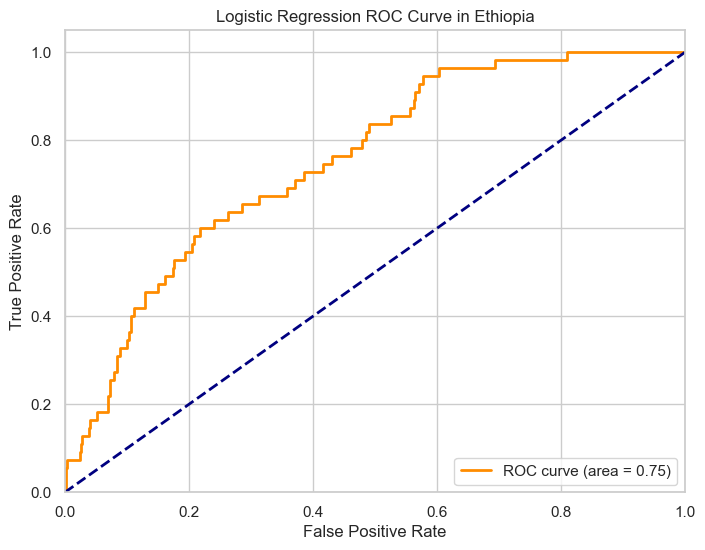

In [16]:
# Draw ROC curve
fpr, tpr, thresholds = roc_curve(Y_test_Ethiopia, lr_score_Ethiopia)
roc_auc = auc(fpr, tpr)

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve in Ethiopia')
plt.legend(loc="lower right")

# Use seaborn for more beautiful aesthetics
sns.set_style("whitegrid")

# plt.show()
plt.savefig('lr_roc_E.jpg')

### Decision Tree, SMOTE=0.6

In [17]:
dt_model_Ethiopia = DecisionTreeClassifier(max_depth=3, random_state=42)
dt_model_Ethiopia.fit(X_train_Ethiopia_smote_06, Y_train_Ethiopia_smote_06)
dt_predict_Ethiopia = dt_model_Ethiopia.predict(X_test_Ethiopia)
dt_score_Ethiopia = dt_model_Ethiopia.predict_proba(X_test_Ethiopia)[:,1]
dt_auc_Ethiopia = roc_auc_score(Y_test_Ethiopia, dt_score_Ethiopia)
print('roc_auc_score for Decision Tree in Ethiopic data: ', dt_auc_Ethiopia)
print('Confidence interval for AUC in Decision Tree is: ', roc_auc_ci(Y_test_Ethiopia, dt_score_Ethiopia, dt_auc_Ethiopia))

roc_auc_score for Decision Tree in Ethiopic data:  0.7517512035163608
Confidence interval for AUC in Decision Tree is:  (0.6765817690064504, 0.8269206380262712)


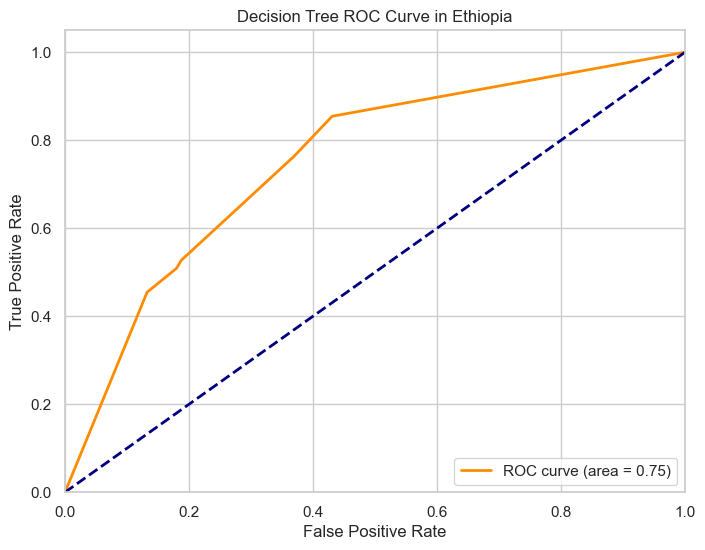

In [18]:
# Draw ROC curve
fpr, tpr, thresholds = roc_curve(Y_test_Ethiopia, dt_score_Ethiopia)
roc_auc = auc(fpr, tpr)

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Decision Tree ROC Curve in Ethiopia')
plt.legend(loc="lower right")

# Use seaborn for more beautiful aesthetics
sns.set_style("whitegrid")

# plt.show()
plt.savefig('dt_roc_E.jpg')

### Linear SVM, SMOTE=1

In [15]:
svm_model_Ethiopia = SVC(kernel='linear', probability=True)
svm_model_Ethiopia.fit(X_train_Ethiopia_smote_1, Y_train_Ethiopia_smote_1)
svm_predict_Ethiopia = svm_model_Ethiopia.predict(X_test_Ethiopia)
svm_score_Ethiopia = svm_model_Ethiopia.predict_proba(X_test_Ethiopia)[:,1]
svm_auc_Ethiopia = roc_auc_score(Y_test_Ethiopia, svm_score_Ethiopia)
print('roc_auc_score for Linear Support Vectore Machine in Ethiopic data: ', svm_auc_Ethiopia)
print('Confidence interval for AUC in Linear SVM is: ', roc_auc_ci(Y_test_Ethiopia, svm_score_Ethiopia, svm_auc_Ethiopia))

roc_auc_score for Linear Support Vectore Machine in Ethiopic data:  0.7402323309844415
Confidence interval for AUC in Linear SVM is:  (0.6642498438388328, 0.8162148181300503)


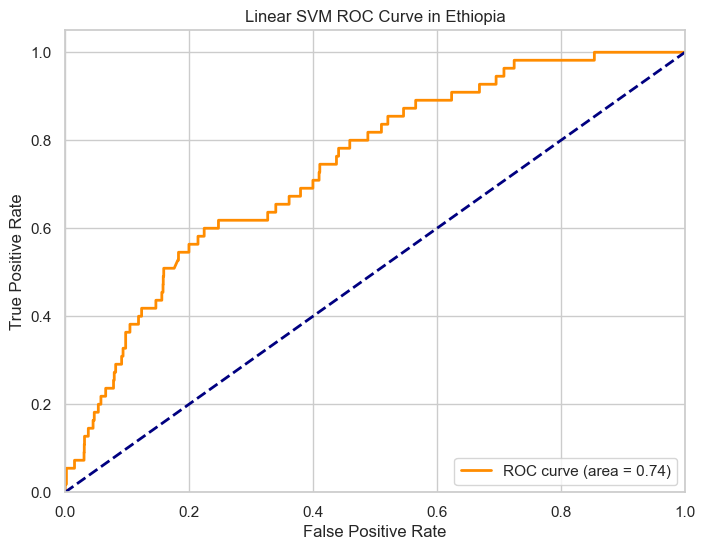

In [16]:
# Draw ROC curve
fpr, tpr, thresholds = roc_curve(Y_test_Ethiopia, svm_score_Ethiopia)
roc_auc = auc(fpr, tpr)

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Linear SVM ROC Curve in Ethiopia')
plt.legend(loc="lower right")

# Use seaborn for more beautiful aesthetics
sns.set_style("whitegrid")

# plt.show()
plt.savefig('svm_roc_E.jpg')

### KNN, SMOTE=1

In [19]:
knn_model_Ethiopia = knn_model = KNeighborsClassifier(n_neighbors=80)
knn_model_Ethiopia.fit(X_train_Ethiopia_smote_1, Y_train_Ethiopia_smote_1)
knn_predict_Ethiopia = knn_model_Ethiopia.predict(X_test_Ethiopia)
knn_score_Ethiopia = knn_model_Ethiopia.predict_proba(X_test_Ethiopia)[:,1]
knn_auc_Ethiopia = roc_auc_score(Y_test_Ethiopia, knn_score_Ethiopia)
print('roc_auc_score for K-nearest Neighbors in Ethiopic data: ', knn_auc_Ethiopia)
print('Confidence interval for AUC in KNN is: ', roc_auc_ci(Y_test_Ethiopia, knn_score_Ethiopia, knn_auc_Ethiopia))

roc_auc_score for K-nearest Neighbors in Ethiopic data:  0.5437033419381846
Confidence interval for AUC in KNN is:  (0.464836342675048, 0.6225703412013213)


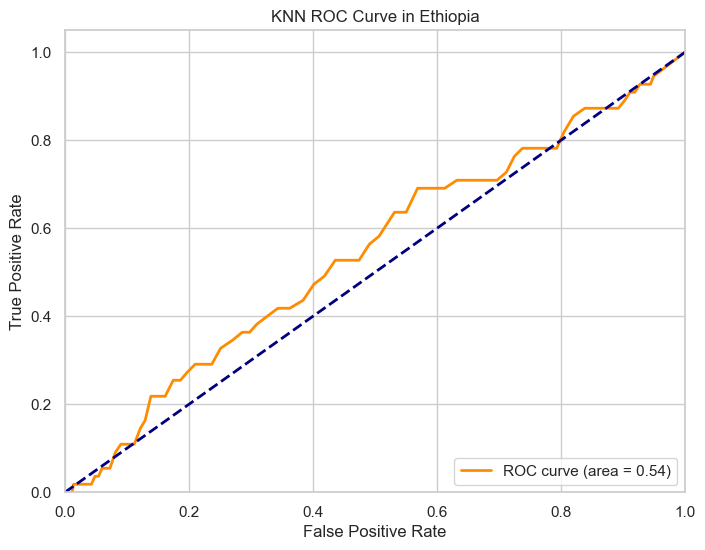

In [20]:
# Draw ROC curve
fpr, tpr, thresholds = roc_curve(Y_test_Ethiopia, knn_score_Ethiopia)
roc_auc = auc(fpr, tpr)

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('KNN ROC Curve in Ethiopia')
plt.legend(loc="lower right")

# Use seaborn for more beautiful aesthetics
sns.set_style("whitegrid")

# plt.show()
plt.savefig('knn_roc_E.jpg')

### Random Forest, SMOTE=0.1

In [21]:
rf_model_Ethiopia = RandomForestClassifier(n_estimators=17, max_depth=5, random_state=42)
rf_model_Ethiopia.fit(X_train_Ethiopia_smote_01, Y_train_Ethiopia_smote_01)
rf_predict_Ethiopia = rf_model_Ethiopia.predict(X_test_Ethiopia)
rf_score_Ethiopia = rf_model_Ethiopia.predict_proba(X_test_Ethiopia)[:,1]
rf_auc_Ethiopia = roc_auc_score(Y_test_Ethiopia, rf_score_Ethiopia)
print('roc_auc_score for Random Forest in Ethiopic data: ', rf_auc_Ethiopia)
print('Confidence interval for AUC in Random Forest is: ', roc_auc_ci(Y_test_Ethiopia, rf_score_Ethiopia, rf_auc_Ethiopia))

roc_auc_score for Random Forest in Ethiopic data:  0.7631723993581245
Confidence interval for AUC in Random Forest is:  (0.6888951559043806, 0.8374496428118685)


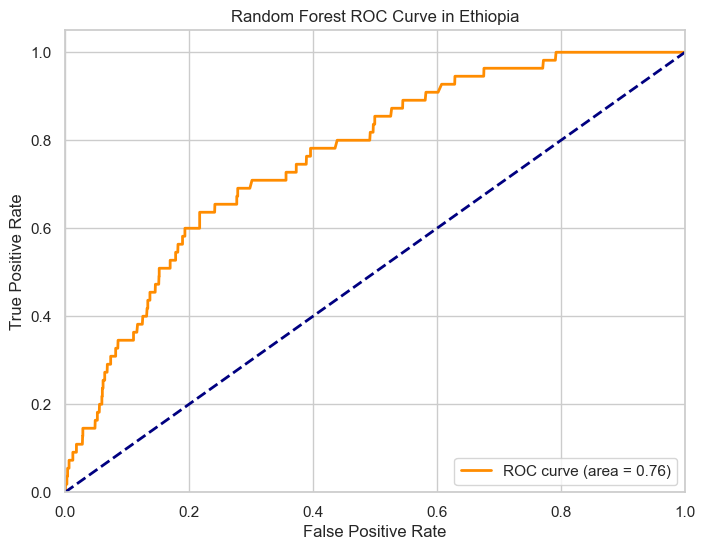

In [22]:
# Draw ROC curve
fpr, tpr, thresholds = roc_curve(Y_test_Ethiopia, rf_score_Ethiopia)
roc_auc = auc(fpr, tpr)

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest ROC Curve in Ethiopia')
plt.legend(loc="lower right")

# Use seaborn for more beautiful aesthetics
sns.set_style("whitegrid")

# plt.show()
plt.savefig('rf_roc_E.jpg')

### Adaboosting, SMOTE=0

In [24]:
ada_model_Ethiopia = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1, random_state=42), learning_rate=0.05, n_estimators=150, random_state=42)
ada_model_Ethiopia.fit(X_train_Ethiopia, Y_train_Ethiopia)
ada_predict_Ethiopia = ada_model_Ethiopia.predict(X_test_Ethiopia)
ada_score_Ethiopia = ada_model_Ethiopia.predict_proba(X_test_Ethiopia)[:,1]
ada_auc_Ethiopia = roc_auc_score(Y_test_Ethiopia, ada_score_Ethiopia)
print('roc_auc_score for Adaboosting in Ethiopic data: ', ada_auc_Ethiopia)
print('Confidence interval for AUC in Adaboosting is: ', roc_auc_ci(Y_test_Ethiopia, ada_score_Ethiopia, ada_auc_Ethiopia))


/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


roc_auc_score for Adaboosting in Ethiopic data:  0.7732261215377102
Confidence interval for AUC in Adaboosting is:  (0.6998082741785694, 0.846643968896851)


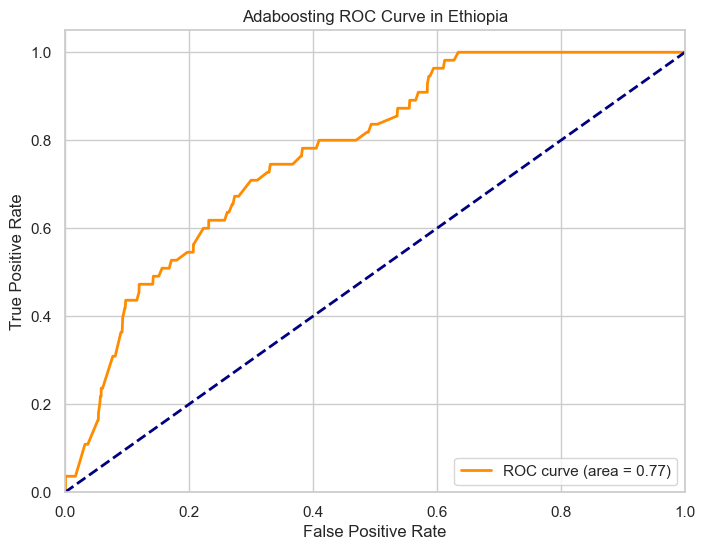

In [25]:
# Draw ROC curve
fpr, tpr, thresholds = roc_curve(Y_test_Ethiopia, ada_score_Ethiopia)
roc_auc = auc(fpr, tpr)

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Adaboosting ROC Curve in Ethiopia')
plt.legend(loc="lower right")

# Use seaborn for more beautiful aesthetics
sns.set_style("whitegrid")

# plt.show()
plt.savefig('ada_roc_E.jpg')

### Bagging, SMOTE=1

In [19]:
bag_model_Ethiopia = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=3, random_state=42), max_features=0.7, max_samples=1.0, n_estimators=100, random_state=42)
bag_model_Ethiopia.fit(X_train_Ethiopia_smote_1_scaled, Y_train_Ethiopia_smote_1_scaled)
bag_predict_Ethiopia = bag_model_Ethiopia.predict(X_test_Ethiopia_scaled)
bag_score_Ethiopia = bag_model_Ethiopia.predict_proba(X_test_Ethiopia_scaled)[:,1]
bag_auc_Ethiopia = roc_auc_score(Y_test_Ethiopia, bag_score_Ethiopia)
print('roc_auc_score for Bagging in Guinean data (without resampling): ', bag_auc_Ethiopia)
print('Confidence interval for AUC in Bagging is: ', roc_auc_ci(Y_test_Ethiopia, bag_score_Ethiopia, bag_auc_Ethiopia))


/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


roc_auc_score for Bagging in Guinean data (without resampling):  0.7755808274611038
Confidence interval for AUC in Bagging is:  (0.7023746155750886, 0.848787039347119)


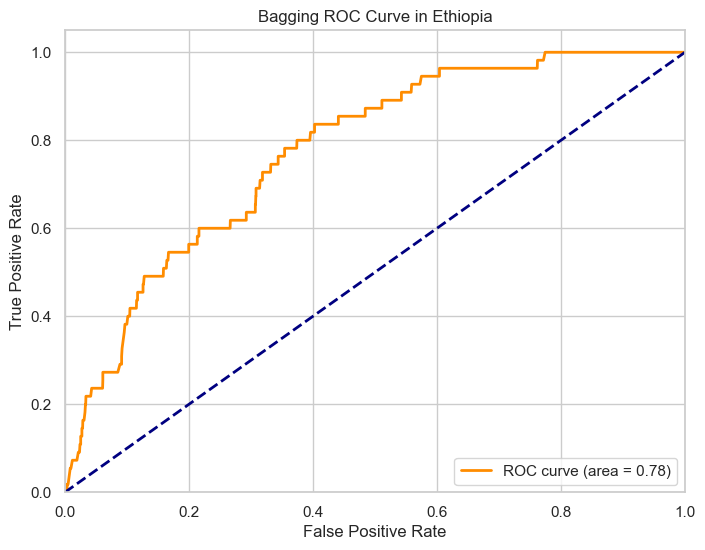

In [28]:
# Draw ROC curve
fpr, tpr, thresholds = roc_curve(Y_test_Ethiopia, bag_score_Ethiopia)
roc_auc = auc(fpr, tpr)

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Bagging ROC Curve in Ethiopia')
plt.legend(loc="lower right")

# Use seaborn for more beautiful aesthetics
sns.set_style("whitegrid")

# plt.show()
plt.savefig('bag_roc_E.jpg')

### Gradient Boosting, SMOTE=0.9

In [29]:
gb_model_Ethiopia = GradientBoostingClassifier(learning_rate=0.01, max_depth=3, n_estimators=275, random_state=42)
gb_model_Ethiopia.fit(X_train_Ethiopia_smote_09_scaled, Y_train_Ethiopia_smote_09_scaled)
gb_predict_Ethiopia = gb_model_Ethiopia.predict(X_test_Ethiopia_scaled)
gb_score_Ethiopia = gb_model_Ethiopia.predict_proba(X_test_Ethiopia_scaled)[:,1]
gb_auc_Ethiopia = roc_auc_score(Y_test_Ethiopia, gb_score_Ethiopia)
print('roc_auc_score for Gradient Boosting in Ethiopic data: ', gb_auc_Ethiopia)
print('Confidence interval for AUC in Gradient Boosting is: ', roc_auc_ci(Y_test_Ethiopia, gb_score_Ethiopia, gb_auc_Ethiopia))

roc_auc_score for Gradient Boosting in Ethiopic data:  0.7750575594781275
Confidence interval for AUC in Gradient Boosting is:  (0.701803972022837, 0.848311146933418)


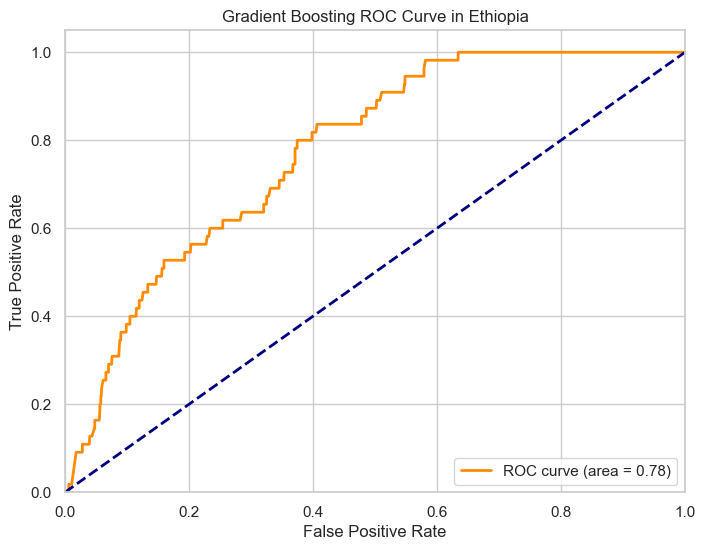

In [31]:
# Draw ROC curve
fpr, tpr, thresholds = roc_curve(Y_test_Ethiopia, gb_score_Ethiopia)
roc_auc = auc(fpr, tpr)

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Gradient Boosting ROC Curve in Ethiopia')
plt.legend(loc="lower right")

# Use seaborn for more beautiful aesthetics
sns.set_style("whitegrid")

# plt.show()
plt.savefig('gb_roc_E.jpg')

## OOD generalization

Do same steps for data from Guinea

In [27]:
# Data from Guinea
Births_Guinea = pd.read_sas('Births_Guinea.SAS7BDAT')
print(Births_Guinea.shape)

# 'M19': Birth_Weight: Birth weight in kilograms (3 decimals) [Original Response variable]
print("The number of valid samples in the dataset is " + str(len(Births_Guinea['M19'].dropna())))
                                                            
Births_Guinea.head()


(28887, 1169)
The number of valid samples in the dataset is 7951


,CASEID,BIDX,V000,V001,V002,V003,V004,V005,V006,V007,...,S425E5,IDX95,S508VA,S508VAD,S508VAM,S508VAY,S519A,S519B,S519C,S519D
0,b' 1 35 2',1.0,b'GN7',1.0,35.0,2.0,1.0,364676.0,5.0,2018.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,b' 1 35 2',2.0,b'GN7',1.0,35.0,2.0,1.0,364676.0,5.0,2018.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,b' 1 38 2',1.0,b'GN7',1.0,38.0,2.0,1.0,364676.0,5.0,2018.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,b' 1 38 2',2.0,b'GN7',1.0,38.0,2.0,1.0,364676.0,5.0,2018.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,b' 1 38 2',3.0,b'GN7',1.0,38.0,2.0,1.0,364676.0,5.0,2018.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
Births_Guinea_df = Births_Guinea[['M19','V026','V106','H42','V190','V445','V447A','V457','V463A','V481','V717','V131',
                  'V501','V130','B4','B0','M14','M17']]
Births_Guinea_df.columns = ['Birth_Weight','Residence','Education','Iron','Wealth','BMI','Age_W','Anemia',
                     'Smoking','Insurance','Occupation','Ethnicity','Marital','Religion','Gender',
                    'Twin','Visits','Delivery_Caesarean']
Births_Guinea_df = Births_Guinea_df.dropna(subset=['Birth_Weight'])
Births_Guinea_df = Births_Guinea_df.reset_index()
Births_Guinea_df = Births_Guinea_df.iloc[:,1:]
print(Births_Guinea_df.shape)
Births_Guinea_df.head()

(7951, 18)


,Birth_Weight,Residence,Education,Iron,Wealth,BMI,Age_W,Anemia,Smoking,Insurance,Occupation,Ethnicity,Marital,Religion,Gender,Twin,Visits,Delivery_Caesarean
0,9998.0,1.0,3.0,0.0,4.0,3259.0,25.0,4.0,0.0,0.0,1.0,2.0,1.0,1.0,1.0,0.0,3.0,0.0
1,9996.0,1.0,0.0,0.0,3.0,1982.0,38.0,3.0,0.0,0.0,0.0,2.0,1.0,1.0,1.0,0.0,6.0,0.0
2,9996.0,1.0,0.0,0.0,4.0,3262.0,40.0,4.0,0.0,0.0,0.0,2.0,1.0,1.0,1.0,0.0,4.0,0.0
3,3600.0,1.0,1.0,0.0,5.0,NaN,NaN,NaN,0.0,0.0,3.0,2.0,1.0,1.0,1.0,0.0,3.0,0.0
4,4300.0,1.0,0.0,0.0,5.0,NaN,NaN,NaN,0.0,0.0,0.0,2.0,1.0,1.0,2.0,0.0,4.0,1.0


In [29]:
# Categorical variables: one-hot encoding
enc = OneHotEncoder(sparse=False)
encoded_array = enc.fit_transform(Births_Guinea_df[['Residence', 'Education', 'Iron', 'Wealth', 'Anemia', 'Smoking', 'Insurance', 'Occupation', 'Ethnicity', 'Marital', 'Religion', 'Gender', 'Twin', 'Delivery_Caesarean']])

encoded_cols = enc.get_feature_names_out(['Residence', 'Education', 'Iron', 'Wealth', 'Anemia', 'Smoking', 'Insurance', 'Occupation', 'Ethnicity', 'Marital', 'Religion', 'Gender', 'Twin', 'Delivery_Caesarean'])
encoded_df = pd.DataFrame(encoded_array, columns=encoded_cols)

# Drop the original columns that were encoded & concatenate with the other columns
Births_Guinea_encoded = pd.concat([Births_Guinea_df.drop(['Residence', 'Education', 'Iron', 'Wealth', 'Anemia', 'Smoking', 'Insurance', 'Occupation', 'Ethnicity', 'Marital', 'Religion', 'Gender', 'Twin', 'Delivery_Caesarean'], axis=1), encoded_df], axis=1)

# Drop the encoded columns showing NA or missing value
Births_Guinea_encoded = Births_Guinea_encoded.drop(['Iron_8.0', 'Iron_nan', 'Anemia_nan', 'Occupation_10.0', 'Occupation_96.0', 'Occupation_98.0', 'Ethnicity_97.0', 'Delivery_Caesarean_nan'], axis=1)
# Births_Guinea_encoded.head()

/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


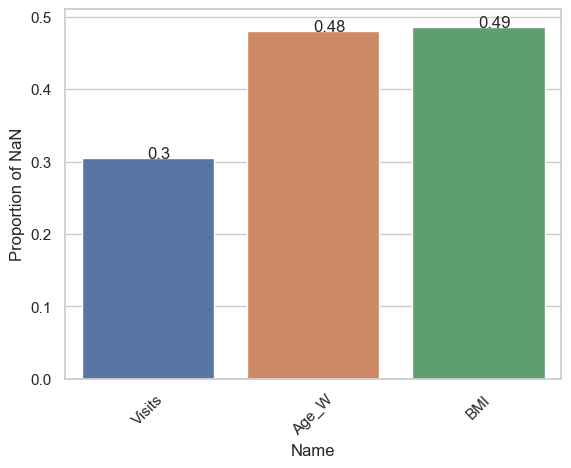

In [30]:
# Numerical variables: imputation
missing_values = Births_Guinea_encoded.isnull().sum() / len(Births_Guinea_encoded)
missing_values = missing_values[missing_values > 0]
missing_values.sort_values(inplace=True)
missing_values = missing_values.to_frame()
missing_values.columns = ['Proportion of NaN']
missing_values.index.names = ['Name']
missing_values['Name'] = missing_values.index

sns.set(style="whitegrid", color_codes=True)
sns.barplot(x = 'Name', y = 'Proportion of NaN', data=missing_values)
plt.xticks(rotation = 45)
addlabels(missing_values['Name'], y=missing_values['Proportion of NaN'])
plt.show()

In [31]:
# Impute with mean simpleImputer
imputer_sim = SimpleImputer(strategy = "mean")
imputed_df_sim = imputer_sim.fit_transform(Births_Guinea_encoded)
Births_Guinea_imputed = pd.DataFrame(imputed_df_sim)
Births_Guinea_imputed.columns = Births_Guinea_encoded.columns
# Births_Guinea_imputed.head()

In [32]:
# Response variable engineering
Births_Guinea_imputed["Is_LBW"] = Births_Guinea_imputed["Birth_Weight"]<2500
Births_Guinea_res = Births_Guinea_imputed.drop(['Birth_Weight'], axis=1)
# Births_Guinea_res.head()

In [33]:
Y_Guinea = Births_Guinea_res["Is_LBW"]
Feature_Guinea = Births_Guinea_res.drop(["Is_LBW"], axis=1)

In [34]:
# Lasso for feature selection
lasso = LogisticRegression(penalty='l1', solver='liblinear', C=1.0, random_state=42)
lasso.fit(Feature_Guinea, Y_Guinea)

coefficients = lasso.coef_[0]
# Identify columns that were dropped (coefficients are zero)
selected_columns = Feature_Guinea.columns[coefficients != 0]
# print("Selected columns:", selected_columns)

# Select features based on the weights after Lasso regularization
feature_model = SelectFromModel(lasso, prefit=True)

# Transform the dataset to only include the selected features
Feature_new = feature_model.transform(Feature_Guinea)

# Update Feature df
Feature_Guinea = pd.DataFrame(Feature_new, columns = ['BMI', 'Age_W', 'Visits', 'Residence_2.0', 'Education_1.0',
       'Education_2.0', 'Education_3.0', 'Iron_1.0', 'Wealth_1.0',
       'Wealth_2.0', 'Wealth_5.0', 'Anemia_1.0', 'Anemia_2.0', 'Anemia_3.0',
       'Anemia_4.0', 'Smoking_1.0', 'Insurance_0.0', 'Occupation_0.0',
       'Occupation_1.0', 'Occupation_2.0', 'Occupation_3.0', 'Occupation_4.0',
       'Occupation_7.0', 'Occupation_9.0', 'Ethnicity_1.0', 'Ethnicity_2.0',
       'Ethnicity_3.0', 'Ethnicity_4.0', 'Ethnicity_5.0', 'Ethnicity_6.0',
       'Marital_0.0', 'Marital_2.0', 'Marital_3.0', 'Marital_5.0',
       'Religion_1.0', 'Religion_2.0', 'Religion_4.0', 'Gender_1.0',
       'Twin_0.0', 'Delivery_Caesarean_0.0', 'Delivery_Caesarean_1.0'])
# Feature_Guinea.head()

/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


In [35]:
# Whole Guinea df after data pre-processing
Guinea_final = pd.concat([Feature_Guinea, Y_Guinea], 1)
Guinea_final.head()

/var/folders/nl/c2qd572x47jc6xs5b3g_cp800000gn/T/ipykernel_34302/2160439458.py:2: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  Guinea_final = pd.concat([Feature_Guinea, Y_Guinea], 1)


,BMI,Age_W,Visits,Residence_2.0,Education_1.0,Education_2.0,Education_3.0,Iron_1.0,Wealth_1.0,Wealth_2.0,...,Marital_3.0,Marital_5.0,Religion_1.0,Religion_2.0,Religion_4.0,Gender_1.0,Twin_0.0,Delivery_Caesarean_0.0,Delivery_Caesarean_1.0,Is_LBW
0,3259.000000,25.000000,3.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,False
1,1982.000000,38.000000,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,False
2,3262.000000,40.000000,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,False
3,2337.963298,29.100484,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,False
4,2337.963298,29.100484,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,False


In [36]:
# Split training and testing set
X_train_Guinea, X_test_Guinea, Y_train_Guinea, Y_test_Guinea = train_test_split(Feature_Guinea, Y_Guinea, test_size=0.25, random_state=42)

In [37]:
# Scale X if needed
scaler = StandardScaler()
X_train_Guinea_scaled = scaler.fit_transform(X_train_Guinea)
X_test_Guinea_scaled = scaler.transform(X_test_Guinea)

In [38]:
# Initialize SMOTE
X_train_Guinea_smote_1, Y_train_Guinea_smote_1 = smote_1.fit_resample(X_train_Guinea, Y_train_Guinea)
X_train_Guinea_smote_1_scaled, Y_train_Guinea_smote_1_scaled = smote_1.fit_resample(X_train_Guinea_scaled, Y_train_Guinea)

X_train_Guinea_smote_01, Y_train_Guinea_smote_01 = smote_01.fit_resample(X_train_Guinea, Y_train_Guinea)

X_train_Guinea_smote_06, Y_train_Guinea_smote_06 = smote_06.fit_resample(X_train_Guinea, Y_train_Guinea)

X_train_Guinea_smote_09, Y_train_Guinea_smote_09 = smote_09.fit_resample(X_train_Guinea, Y_train_Guinea)
X_train_Guinea_smote_09_scaled, Y_train_Guinea_smote_09_scaled = smote_09.fit_resample(X_train_Guinea_scaled, Y_train_Guinea)


### Logistic Regression, SMOTE=1

In [44]:
lr_model_Guinea = LogisticRegression(solver='liblinear', random_state=42)
lr_model_Guinea.fit(X_train_Guinea_smote_1, Y_train_Guinea_smote_1)
lr_predict_Guinea = lr_model_Guinea.predict(X_test_Guinea)
lr_score_Guinea = lr_model_Guinea.predict_proba(X_test_Guinea)[:,1]
lr_auc_Guinea = roc_auc_score(Y_test_Guinea, lr_score_Guinea)
print('roc_auc_score for Logistic Regression in Guinean data: ', lr_auc_Guinea)
print('Confidence interval for AUC in Logistic Regression is: ', roc_auc_ci(Y_test_Guinea, lr_score_Guinea, lr_auc_Guinea))


roc_auc_score for Logistic Regression in Guinean data:  0.6256226522946268
Confidence interval for AUC in Logistic Regression is:  (0.5667900143430725, 0.684455290246181)


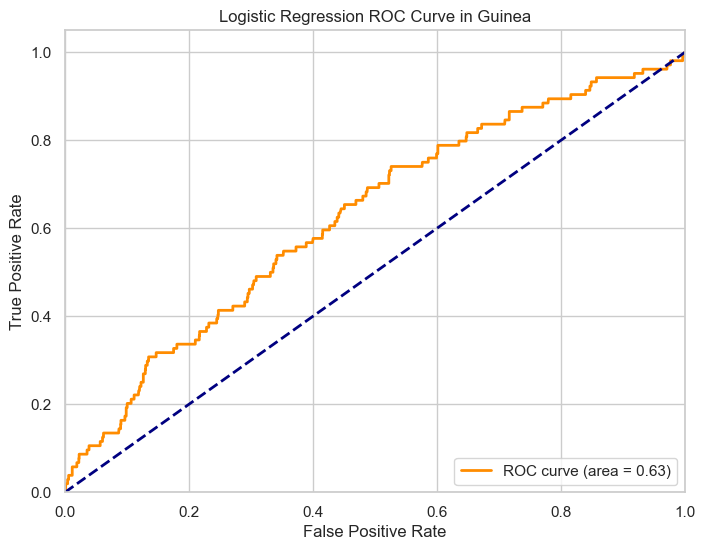

In [45]:
# Draw ROC curve
fpr, tpr, thresholds = roc_curve(Y_test_Guinea, lr_score_Guinea)
roc_auc = auc(fpr, tpr)

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve in Guinea')
plt.legend(loc="lower right")

# Use seaborn for more beautiful aesthetics
sns.set_style("whitegrid")

# plt.show()
plt.savefig('lr_roc_G.jpg')

### Decision Tree, SMOTE=1

In [46]:
dt_model_Guinea = DecisionTreeClassifier(max_depth=3, random_state=42)
dt_model_Guinea.fit(X_train_Guinea_smote_1, Y_train_Guinea_smote_1)
dt_predict_Guinea = dt_model_Guinea.predict(X_test_Guinea)
dt_score_Guinea = dt_model_Guinea.predict_proba(X_test_Guinea)[:,1]
dt_auc_Guinea = roc_auc_score(Y_test_Guinea, dt_score_Guinea)
print('roc_auc_score for Decision Tree in Guinean data: ', dt_auc_Guinea)
print('Confidence interval for AUC in Decision Tree is: ', roc_auc_ci(Y_test_Guinea, dt_score_Guinea, dt_auc_Guinea))

roc_auc_score for Decision Tree in Guinean data:  0.622688020578148
Confidence interval for AUC in Decision Tree is:  (0.563839624120576, 0.68153641703572)


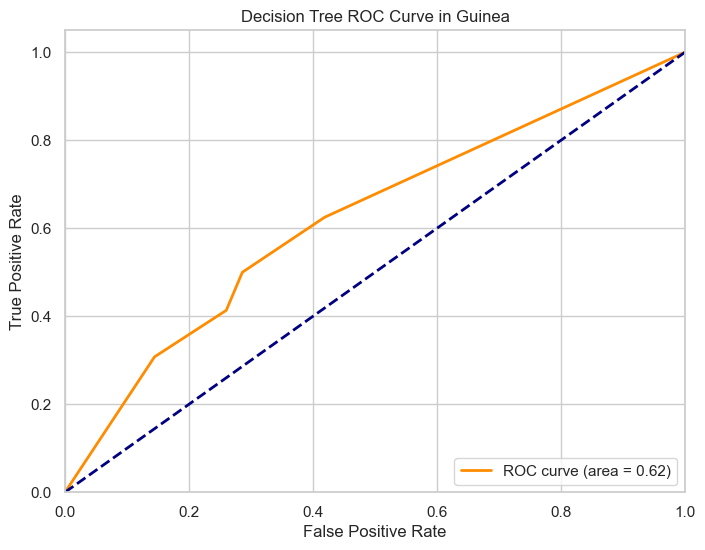

In [47]:
# Draw ROC curve
fpr, tpr, thresholds = roc_curve(Y_test_Guinea, dt_score_Guinea)
roc_auc = auc(fpr, tpr)

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Decision Tree ROC Curve in Guinea')
plt.legend(loc="lower right")

# Use seaborn for more beautiful aesthetics
sns.set_style("whitegrid")

# plt.show()
plt.savefig('dt_roc_G.jpg')

### Linear SVM, SMOTE=1

In [58]:
svm_model_Guinea = SVC(kernel='linear', probability=True)
svm_model_Guinea.fit(X_train_Guinea_smote_1, Y_train_Guinea_smote_1)
svm_predict_Guinea = svm_model_Guinea.predict(X_test_Guinea)
svm_score_Guinea = svm_model_Guinea.predict_proba(X_test_Guinea)[:,1]
svm_auc_Guinea = roc_auc_score(Y_test_Guinea, svm_score_Guinea)
print('roc_auc_score for Linear Support Vectore Machine in Guinean data: ', svm_auc_Guinea)
print('Confidence interval for AUC in SVM is: ', roc_auc_ci(Y_test_Guinea, svm_score_Guinea, svm_auc_Guinea))

roc_auc_score for Linear Support Vectore Machine in Guinean data:  0.6299812183570146
Confidence interval for AUC in SVM is:  (0.5711774600617703, 0.6887849766522589)


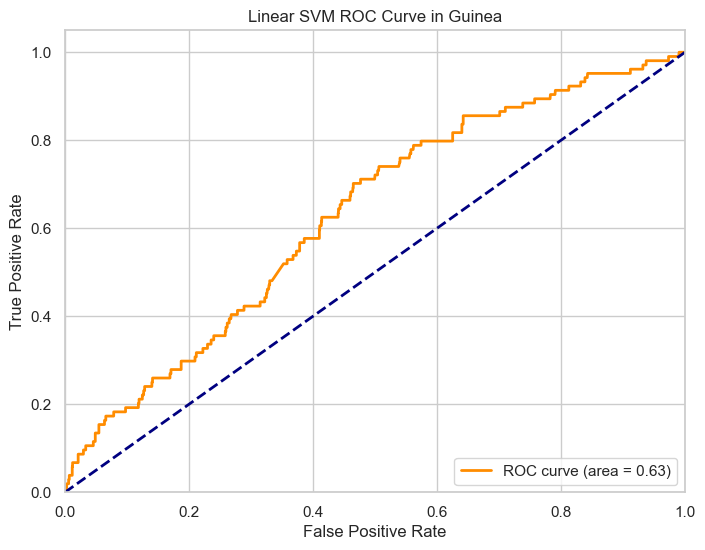

In [59]:
# Draw ROC curve
fpr, tpr, thresholds = roc_curve(Y_test_Guinea, svm_score_Guinea)
roc_auc = auc(fpr, tpr)

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Linear SVM ROC Curve in Guinea')
plt.legend(loc="lower right")

# Use seaborn for more beautiful aesthetics
sns.set_style("whitegrid")

# plt.show()
plt.savefig('svm_roc_G.jpg')

### KNN, SMOTE=1

In [48]:
knn_model_Guinea = knn_model = KNeighborsClassifier(n_neighbors=80)
knn_model_Guinea.fit(X_train_Guinea_smote_1, Y_train_Guinea_smote_1)
knn_predict_Guinea = knn_model_Guinea.predict(X_test_Guinea)
knn_score_Guinea = knn_model_Guinea.predict_proba(X_test_Guinea)[:,1]
knn_auc_Guinea = roc_auc_score(Y_test_Guinea, knn_score_Guinea)
print('roc_auc_score for K-nearest Neighbors in Guinean data: ', knn_auc_Guinea)
print('Confidence interval for AUC in KNN is: ', roc_auc_ci(Y_test_Guinea, knn_score_Guinea, knn_auc_Guinea))

roc_auc_score for K-nearest Neighbors in Guinean data:  0.561338906581741
Confidence interval for AUC in KNN is:  (0.5028170022353201, 0.6198608109281619)


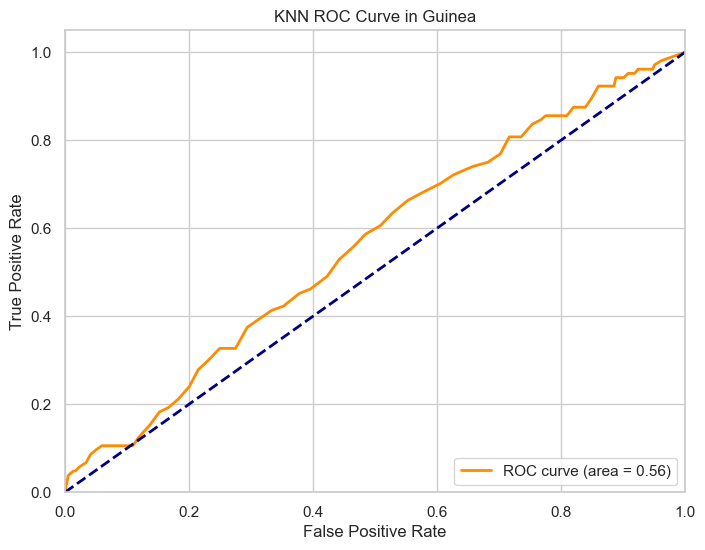

In [49]:
# Draw ROC curve
fpr, tpr, thresholds = roc_curve(Y_test_Guinea, knn_score_Guinea)
roc_auc = auc(fpr, tpr)

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('KNN ROC Curve in Guinea')
plt.legend(loc="lower right")

# Use seaborn for more beautiful aesthetics
sns.set_style("whitegrid")

# plt.show()
plt.savefig('knn_roc_G.jpg')

### Random Forest, SMOTE=0.1

In [39]:
rf_model_Guinea = RandomForestClassifier(n_estimators=17, max_depth=5, random_state=42)
rf_model_Guinea.fit(X_train_Guinea_smote_01, Y_train_Guinea_smote_01)
rf_predict_Guinea = rf_model_Guinea.predict(X_test_Guinea)
rf_score_Guinea = rf_model_Guinea.predict_proba(X_test_Guinea)[:,1]
rf_auc_Guinea = roc_auc_score(Y_test_Guinea, rf_score_Guinea)
print('roc_auc_score for Random Forest in Guinean data: ', rf_auc_Guinea)
print('Confidence interval for AUC in Random Forest is: ', roc_auc_ci(Y_test_Guinea, rf_score_Guinea, rf_auc_Guinea))

roc_auc_score for Random Forest in Guinean data:  0.6900799240568348
Confidence interval for AUC in Random Forest is:  (0.6323708481361431, 0.7477889999775266)


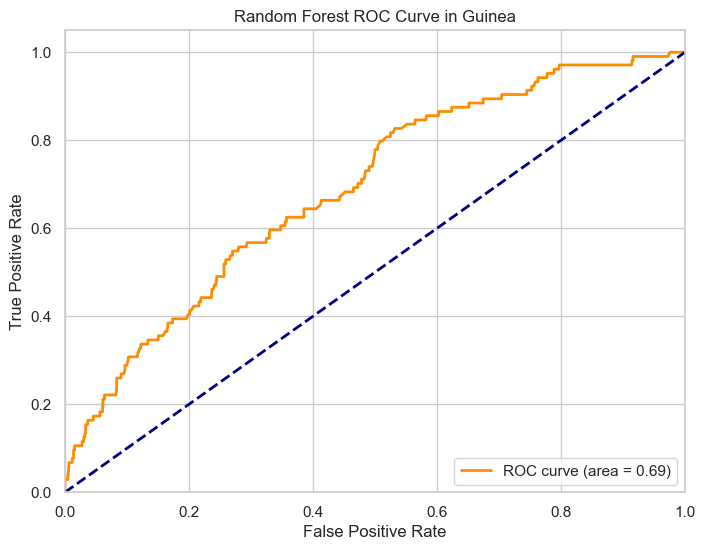

In [40]:
# Draw ROC curve
fpr, tpr, thresholds = roc_curve(Y_test_Guinea, rf_score_Guinea)
roc_auc = auc(fpr, tpr)

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest ROC Curve in Guinea')
plt.legend(loc="lower right")

# Use seaborn for more beautiful aesthetics
sns.set_style("whitegrid")

# plt.show()
plt.savefig('rf_roc_G.jpg')

### Adaboosting, SMOTE=0

In [52]:
ada_model_Guinea = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1, random_state=42), learning_rate=0.05, n_estimators=150, random_state=42)
ada_model_Guinea.fit(X_train_Guinea, Y_train_Guinea)
ada_predict_Guinea = ada_model_Guinea.predict(X_test_Guinea)
ada_score_Guinea = ada_model_Guinea.predict_proba(X_test_Guinea)[:,1]
ada_auc_Guinea = roc_auc_score(Y_test_Guinea, ada_score_Guinea)
print('roc_auc_score for Adaboosting in Guinean data (without resampling): ', ada_auc_Guinea)
print('Confidence interval for AUC in Adaboosting is: ', roc_auc_ci(Y_test_Guinea, ada_score_Guinea, ada_auc_Guinea))


/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


roc_auc_score for Adaboosting in Guinean data (without resampling):  0.6643904131961458
Confidence interval for AUC in Adaboosting is:  (0.6060502950204492, 0.7227305313718424)


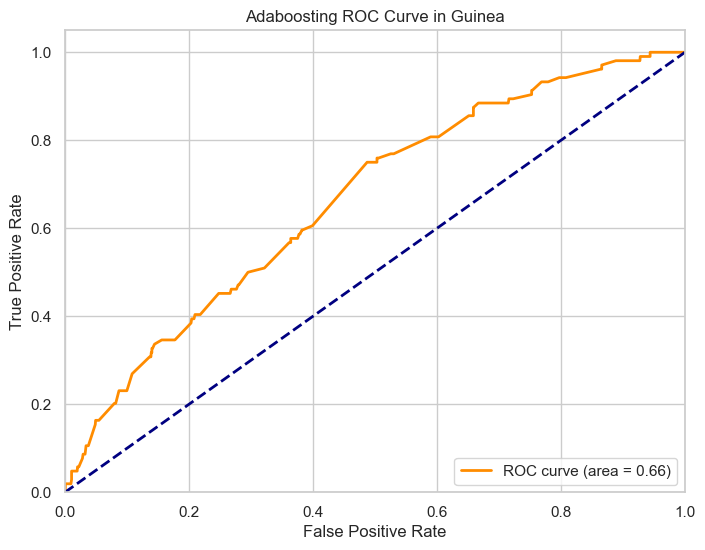

In [53]:
# Draw ROC curve
fpr, tpr, thresholds = roc_curve(Y_test_Guinea, ada_score_Guinea)
roc_auc = auc(fpr, tpr)

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Adaboosting ROC Curve in Guinea')
plt.legend(loc="lower right")

# Use seaborn for more beautiful aesthetics
sns.set_style("whitegrid")

# plt.show()
plt.savefig('ada_roc_G.jpg')

### Bagging, SMOTE=1

In [54]:
bag_model_Guinea = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=3, random_state=42), max_features=0.7, max_samples=1.0, n_estimators=100, random_state=42)
bag_model_Guinea.fit(X_train_Guinea_smote_1_scaled, Y_train_Guinea_smote_1_scaled)
bag_predict_Guinea = bag_model_Guinea.predict(X_test_Guinea_scaled)
bag_score_Guinea = bag_model_Guinea.predict_proba(X_test_Guinea_scaled)[:,1]
bag_auc_Guinea = roc_auc_score(Y_test_Guinea, bag_score_Guinea)
print('roc_auc_score for Bagging in Guinean data: ', bag_auc_Guinea)
print('Confidence interval for AUC in Bagging is: ', roc_auc_ci(Y_test_Guinea, bag_score_Guinea, bag_auc_Guinea))


/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


roc_auc_score for Bagging in Guinean data:  0.665852625347052
Confidence interval for AUC in Bagging is:  (0.6075417196551677, 0.7241635310389364)


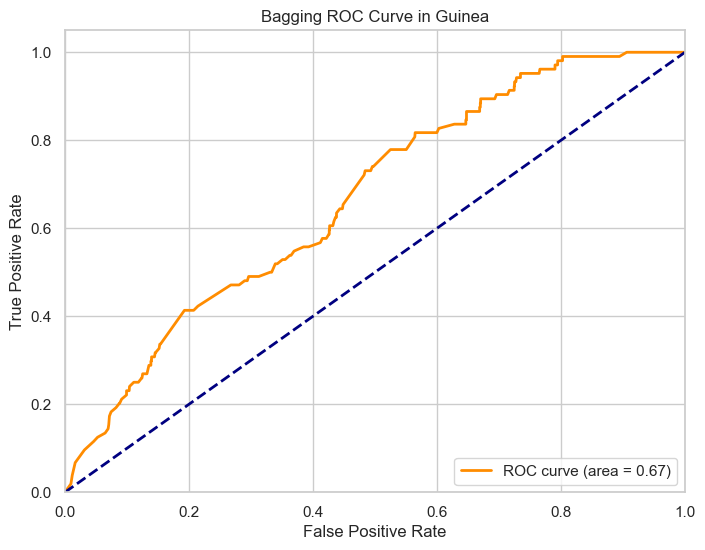

In [55]:
# Draw ROC curve
fpr, tpr, thresholds = roc_curve(Y_test_Guinea, bag_score_Guinea)
roc_auc = auc(fpr, tpr)

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Bagging ROC Curve in Guinea')
plt.legend(loc="lower right")

# Use seaborn for more beautiful aesthetics
sns.set_style("whitegrid")

# plt.show()
plt.savefig('bag_roc_G.jpg')

### Gradient Boosting, SMOTE=0.9

In [56]:
gb_model_Guinea = GradientBoostingClassifier(learning_rate=0.01, max_depth=3, n_estimators=275, random_state=42)
gb_model_Guinea.fit(X_train_Guinea_smote_09_scaled, Y_train_Guinea_smote_09_scaled)
gb_predict_Guinea = gb_model_Guinea.predict(X_test_Guinea_scaled)
gb_score_Guinea = gb_model_Guinea.predict_proba(X_test_Guinea_scaled)[:,1]
gb_auc_Guinea = roc_auc_score(Y_test_Guinea, gb_score_Guinea)
print('roc_auc_score for Gradient Boosting in Guinean data: ', gb_auc_Guinea)
print('Confidence interval for AUC in Gradient Boosting is: ', roc_auc_ci(Y_test_Guinea, gb_score_Guinea, gb_auc_Guinea))

roc_auc_score for Gradient Boosting in Guinean data:  0.6603278621590724
Confidence interval for AUC in Gradient Boosting is:  (0.6019107354653666, 0.7187449888527782)


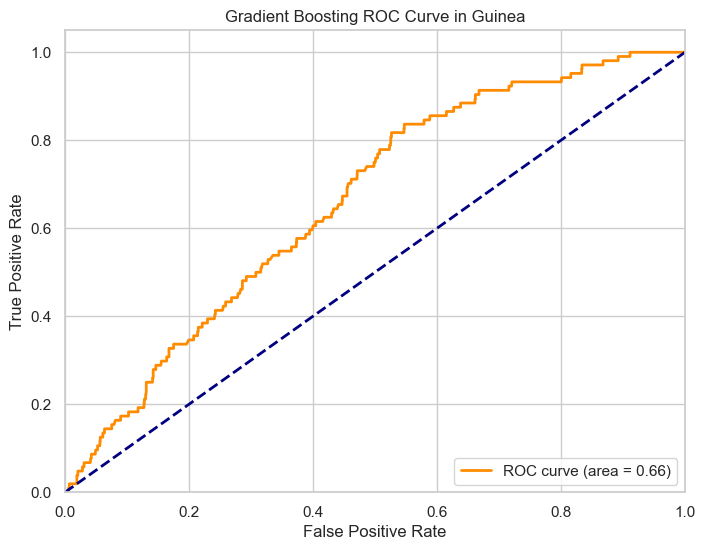

In [57]:
# Draw ROC curve
fpr, tpr, thresholds = roc_curve(Y_test_Guinea, gb_score_Guinea)
roc_auc = auc(fpr, tpr)

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Gradient Boosting ROC Curve in Guinea')
plt.legend(loc="lower right")

# Use seaborn for more beautiful aesthetics
sns.set_style("whitegrid")

# plt.show()
plt.savefig('gb_roc_G.jpg')

## Feature Imbalance Analysis

### Ethiopia

The best model is Bagging with SMOTE=1

In [43]:
# Get feature importances
feature_importance_Ethiopia = np.mean([tree.feature_importances_ for tree in bag_model_Ethiopia.estimators_], axis=0)
feature_name_Ethiopia = [str(Feature_Ethiopia.columns[i]) for i in range(1, len(feature_importance_Ethiopia) + 1)]
feature_importance_Ethiopia = pd.Series(feature_importance_Ethiopia, index=feature_name_Ethiopia)

# Sort features by their importance
feature_importance_Ethiopia = feature_importance_Ethiopia.sort_values(ascending=False)
print(feature_importance_Ethiopia.head(10))

Anemia_3.0        0.075808
Education_3.0     0.057841
Iron_0.0          0.056809
Wealth_1.0        0.055674
Ethnicity_3.0     0.053850
Occupation_2.0    0.049578
Ethnicity_2.0     0.048214
Occupation_9.0    0.046793
Education_0.0     0.044873
Wealth_2.0        0.043118
dtype: float64


### Guinea

The best model is Random Forest with SMOTE=0.1

In [41]:
# Get feature importances
feature_importance_Guinea = rf_model_Guinea.feature_importances_
feature_importance_Guinea = pd.Series(feature_importance_Guinea, index=Feature_Guinea.columns)

# Sort features by their importance
feature_importance_Guinea = feature_importance_Guinea.sort_values(ascending=False)
print(feature_importance_Guinea.head(10))

Ethnicity_1.0             0.136781
Wealth_5.0                0.108759
Twin_0.0                  0.094057
Residence_2.0             0.077315
Iron_1.0                  0.066035
Occupation_4.0            0.065184
Wealth_1.0                0.056164
Delivery_Caesarean_1.0    0.037261
Occupation_0.0            0.034945
Ethnicity_2.0             0.031200
dtype: float64
